# USPEX SXD point-source reduction example

Last updated 23 May 2025

This notebook demonstrates the reduction of a USPEX SXD point-source data using the test data provided with the code in tests/test_data/raw/uspex-SXD

## Steps:
* setup instrument parameters
* reduce calibration data
* extract science point source
* extract telluric standard point source
* combine individual science spectra into one spectrum
* combine individual telluric spectra into one spectrum
* telluric calibration science spectrum


In [1]:
# import package and check
import pyspextool as ps
import os, sys
import numpy as np
import matplotlib.pyplot as plt

help(ps)

Help on package pyspextool:

NAME
    pyspextool

DESCRIPTION
    PySpexTool is a package intended to contain core functionality and some
    common tools needed for performing reduction for SpeX instrument in
    Python.

PACKAGE CONTENTS
    batch (package)
    combine (package)
    config
    extract (package)
    fit (package)
    io (package)
    plot (package)
    pyspextoolerror
    setup_utils
    telluric (package)
    utils (package)

FILE
    /Users/chsu/projects/pyspextool/src/pyspextool/__init__.py




# Setup

While users should be able to run the Jupyter notebook tutorials without changing the output paths, users are encouraged to move the data folder and rename the output paths. Users can define the output paths, including the `cal`, `proc`, and `qa` in the next cell to where users would like to save their data.

In [2]:
# ============================================================================
# CONFIGURATION - Define paths, files, and reduction parameters
# ============================================================================

# Instrument configuration
instrument = 'uspex'        # Upgraded SpeX instrument
inst_mode = 'SXD'        # SXD mode

# Determine data paths
# file_base: Root directory of the pyspextool installation
file_base = ps.__file__.split('/src/')[0]
topbase = os.getenv("HOME")  # User's home directory

# Data directories
# raw: Location of raw FITS files from the telescope
raw = file_base + '/tests/test_data/raw/' + instrument + '-' + inst_mode + '/data/'

# Output directories (users can customize these paths)
cal = topbase + '/test_pyspextool/test_data/processed/' + instrument + '-' + inst_mode + '/cals/'   # Calibration files
proc = topbase + '/test_pyspextool/test_data/processed/' + instrument + '-' + inst_mode + '/proc/' # Processed spectra
qa = topbase + '/test_pyspextool/test_data/processed/' + instrument + '-' + inst_mode + '/qa/'     # QA plots

# File naming prefixes
src_prefix = 'uspc'        # Science and standard star files
flat_prefix = 'uflat'      # Flat field files
arc_prefix = 'uarc'        # Arc lamp files

# ============================================================================
# INPUT FILES - Define which files to use
# ============================================================================

# Target and standard names (customize for your data)
obj_name = 'J1104+1959'    # Science target name
std_name = 'HD101060'      # Telluric standard name

# File number ranges
files = '1-8'              # Science observations
std_files = '9-14'         # Standard observations
flat_files = '15-19'       # Flat fields
wave_files = '20'          # Arc lamps

# ============================================================================
# EXTRACTION PARAMETERS
# ============================================================================

# Observing mode
mode = 'A-B'               # A-B nodding (subtract beam positions)
naps = 1 if mode == 'A' else 2
aperture_signs = None

# Aperture configuration
aperture_find = ['auto',2] # Auto-find with 2-sigma threshold
aperture = 1.5             # Aperture radius (arcsec)
include_orders = None      # Orders to extract (None = all)

# Corrections to apply
correct_bias = True        # Bias correction
correct_linearity = True   # Linearity correction
flat_field = True          # Flat field correction
fix_badpixels = True       # Bad pixel interpolation

# Background subtraction
bg_annulus = [2,2.5]       # Background annulus (inner, outer radius in arcsec)
psf_radius = None          # PSF radius (None = aperture photometry)

# Calibration file names
flatfield_file = 'flat%s.fits' % flat_files
wavecal_file = 'wavecal%s.fits' % wave_files

# ============================================================================
# QA AND OUTPUT SETTINGS
# ============================================================================

verbose = True
qa_show = True             # Display QA plots
qa_write = True            # Save QA plots
qa_extension = '.pdf'
qa_showblock = True
write_model_spectra = False

# Create output directories
for directory in [cal, proc, qa]:
    if not os.path.exists(directory):
        os.makedirs(directory)


In [3]:
# ============================================================================
# GENERATE OUTPUT PREFIX
# ============================================================================
# Build filename prefix encoding applied corrections

output_prefix = mode
if correct_bias is True:  output_prefix += '_bc'
if correct_linearity is True:  output_prefix += '_lc'
if flat_field is True:  output_prefix += '_flat'
if flat_field is not None:  output_prefix += '_wc'
if fix_badpixels is True:  output_prefix += '_fxbdpx'

output_prefix += '-'


In [4]:
# ============================================================================
# INITIALIZE PYSPEXTOOL
# ============================================================================

ps.pyspextool_setup(instrument,
                    raw_path=raw,
                    qa_path=qa,
                    cal_path=cal,
                    proc_path=proc,
                    verbose=verbose,
                    qa_write=qa_write,
                    qa_show=qa_show,
                    qa_showblock=qa_showblock)


INFO:  pySpextool Setup
----------------------

INFO:  Verbose set to True. 
 Logging level set to 20
INFO:  Instrument set to uspex
INFO:  Paths set
INFO:  QA settings set


## Calibrations

INFO:  Generating Flat Field
---------------------------

INFO:  Loading the images.
INFO:  Loading images(s) flat-00021.a.fits, flat-00022.a.fits, flat-00023.a.fits, flat-00024.a.fits, flat-00025.a.fits correcting bias drift, and not correcting for non-linearity.


100% |**********************************************************************|


INFO:  Scaling the images.
INFO:  Medianing the images.
INFO:  Locating the orders.


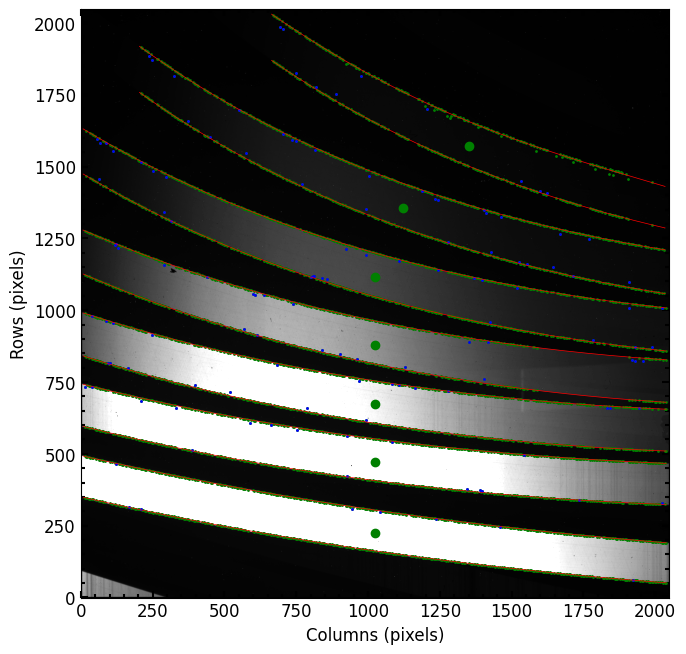

INFO:  Normalizing the median flat.


100% |**********************************************************************|


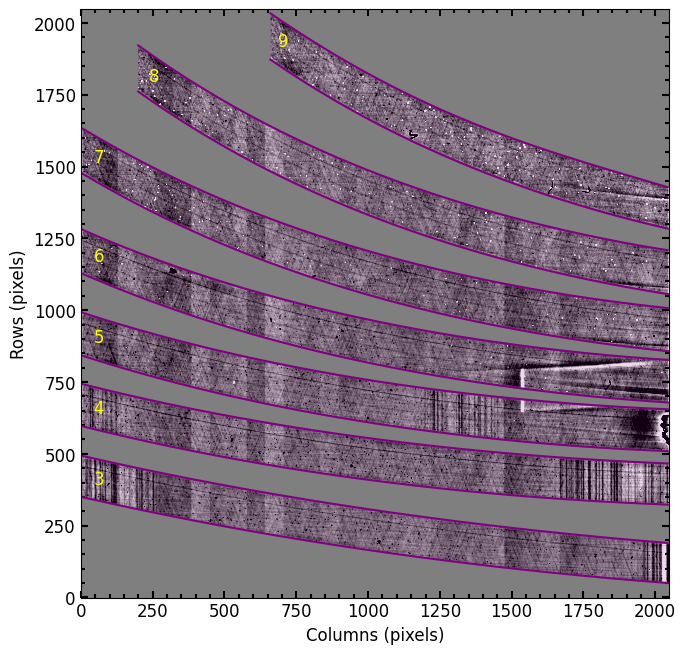

INFO:  Flat field file flat21-25.fits written to disk.

INFO:  Generating Wavelength Solution
------------------------------------

INFO:  Creating the arc image.


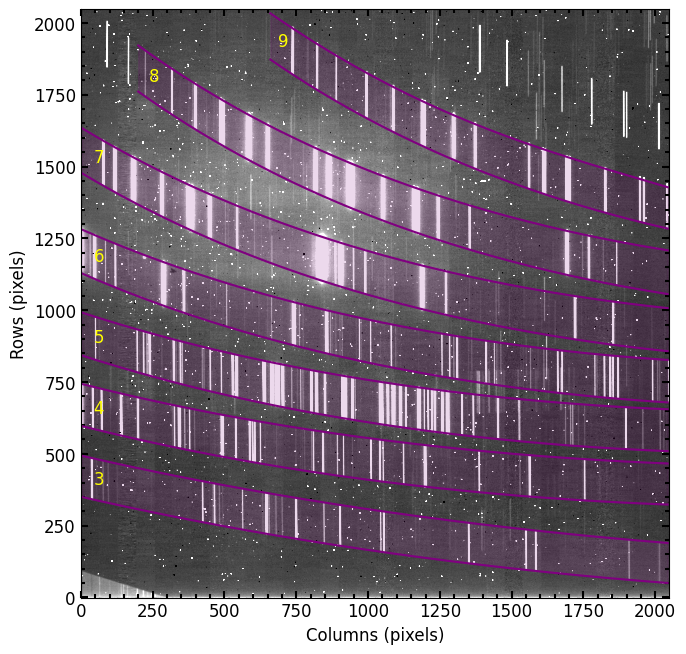

INFO:  Sum extracting 1 aperture in 7 orders (without background subtraction).


100% |**********************************************************************|


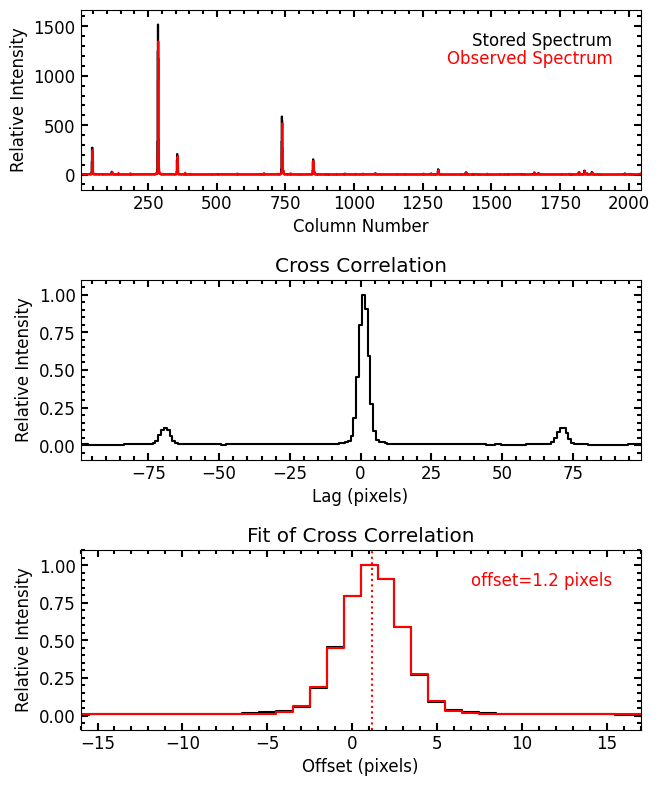

INFO:  Finding the lines.
/Users/chsu/projects/pyspextool/src/pyspextool/fit/fit_peak1d.py:226: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = scipy.optimize.curve_fit(f, xx, yy, p0=p0)
INFO:  Determining the wavelength solution.


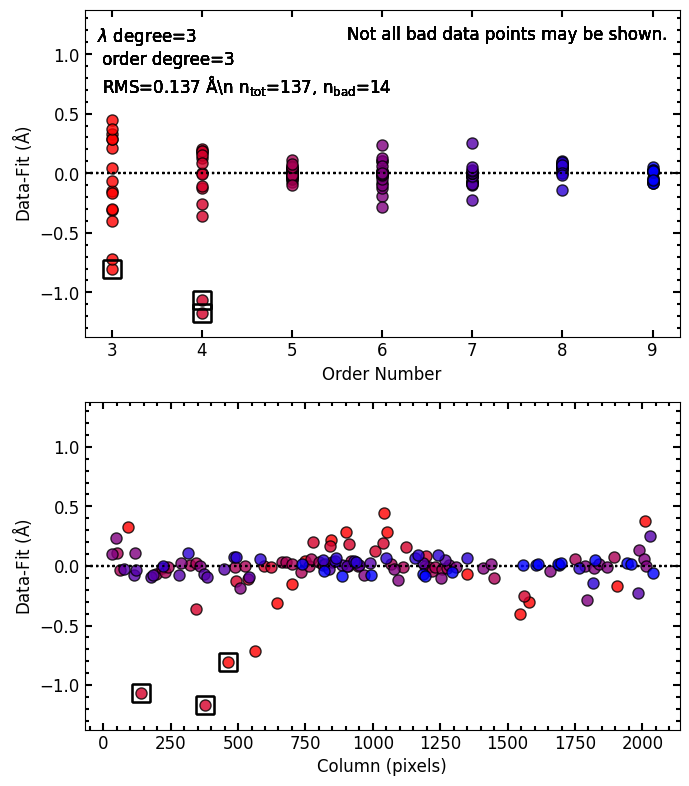

INFO:  Writing wavecal to disk.
INFO:  Wavecal file wavecal26.fits written to disk.



In [5]:
# ============================================================================
# CREATE CALIBRATIONS
# ============================================================================

# Create master flat field
ps.extract.make_flat([flat_prefix, flat_files],
                     flatfield_file.rstrip('.fits'))

# Create wavelength solution from arc lamps
ps.extract.make_wavecal([arc_prefix, wave_files],
                        flatfield_file,
                        wavecal_file.rstrip('.fits'))


## Extract telluric standard files

INFO:  Setting reduction mode to A-B.
INFO:  Loading the flat file flat21-25.fits.
INFO:  Loading the wavecal file wavecal26.fits.
INFO:  Loading the atmospheric tranmission at R=2000.
INFO:  Loading images(s) spc-00011.a.fits, spc-00012.b.fits correcting bias drift, and correcting for non-linearity.


100% |**********************************************************************|


INFO:  Flat fielding the image.
INFO:  Rectifying the orders.


100% |**********************************************************************|


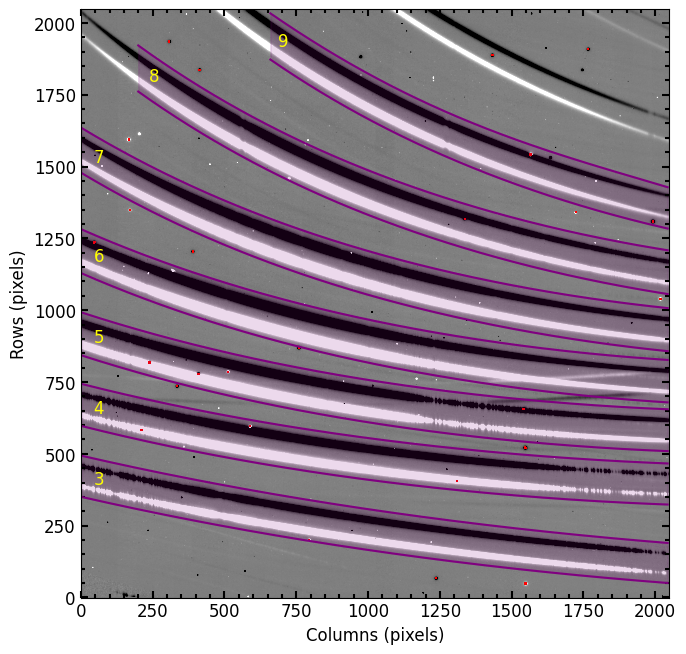

INFO:  Creating the 1D spatial profiles.


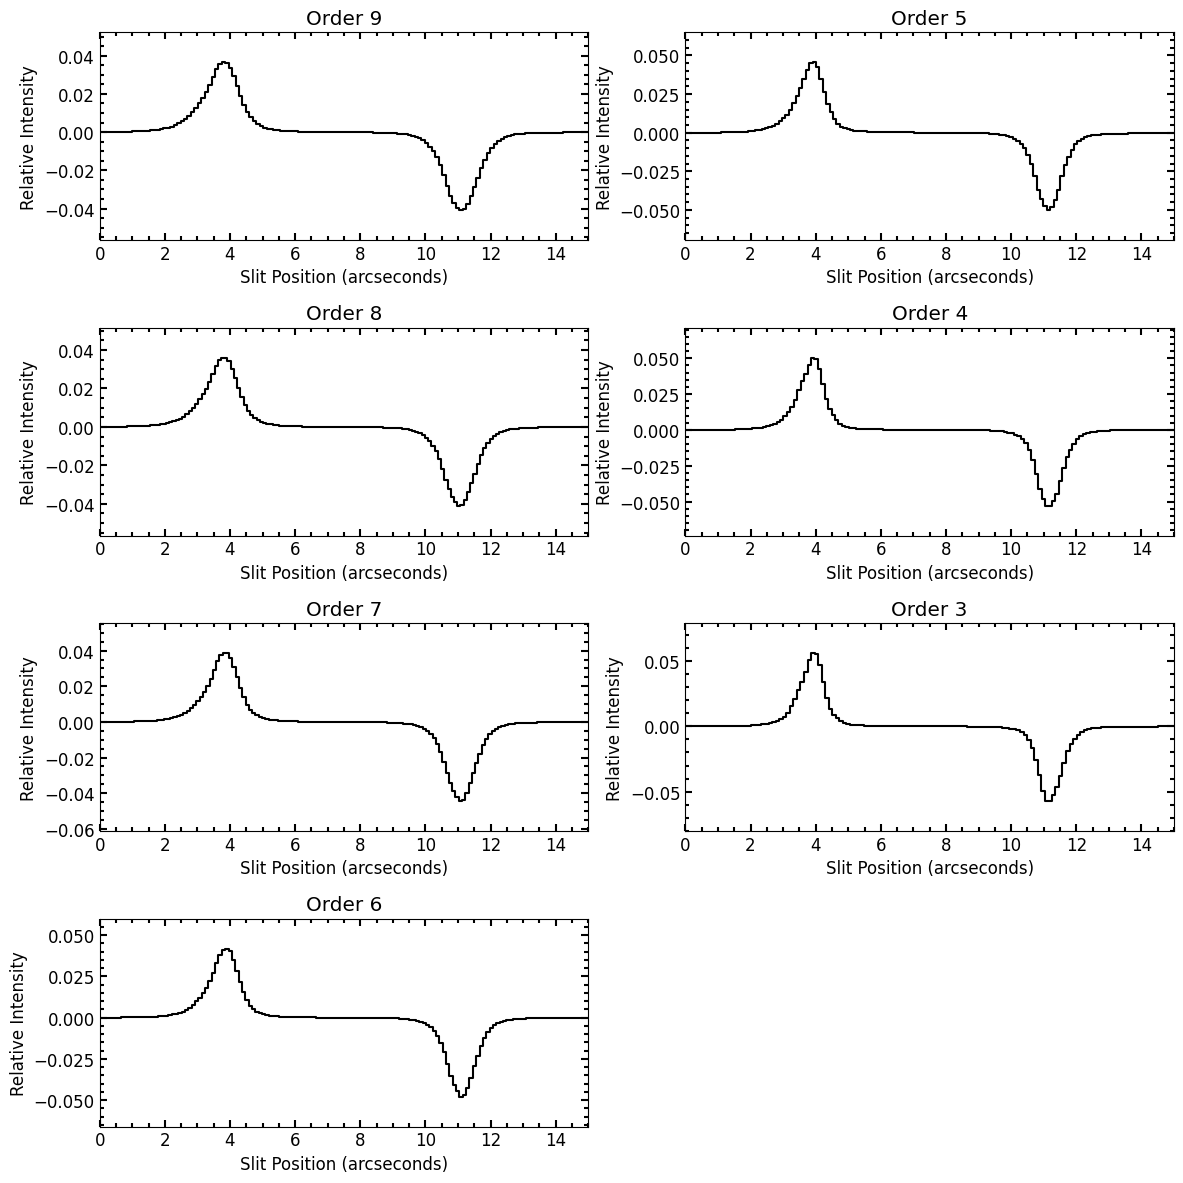

INFO:  Locating the apertures.
INFO:  Aperture signs are (+, -).


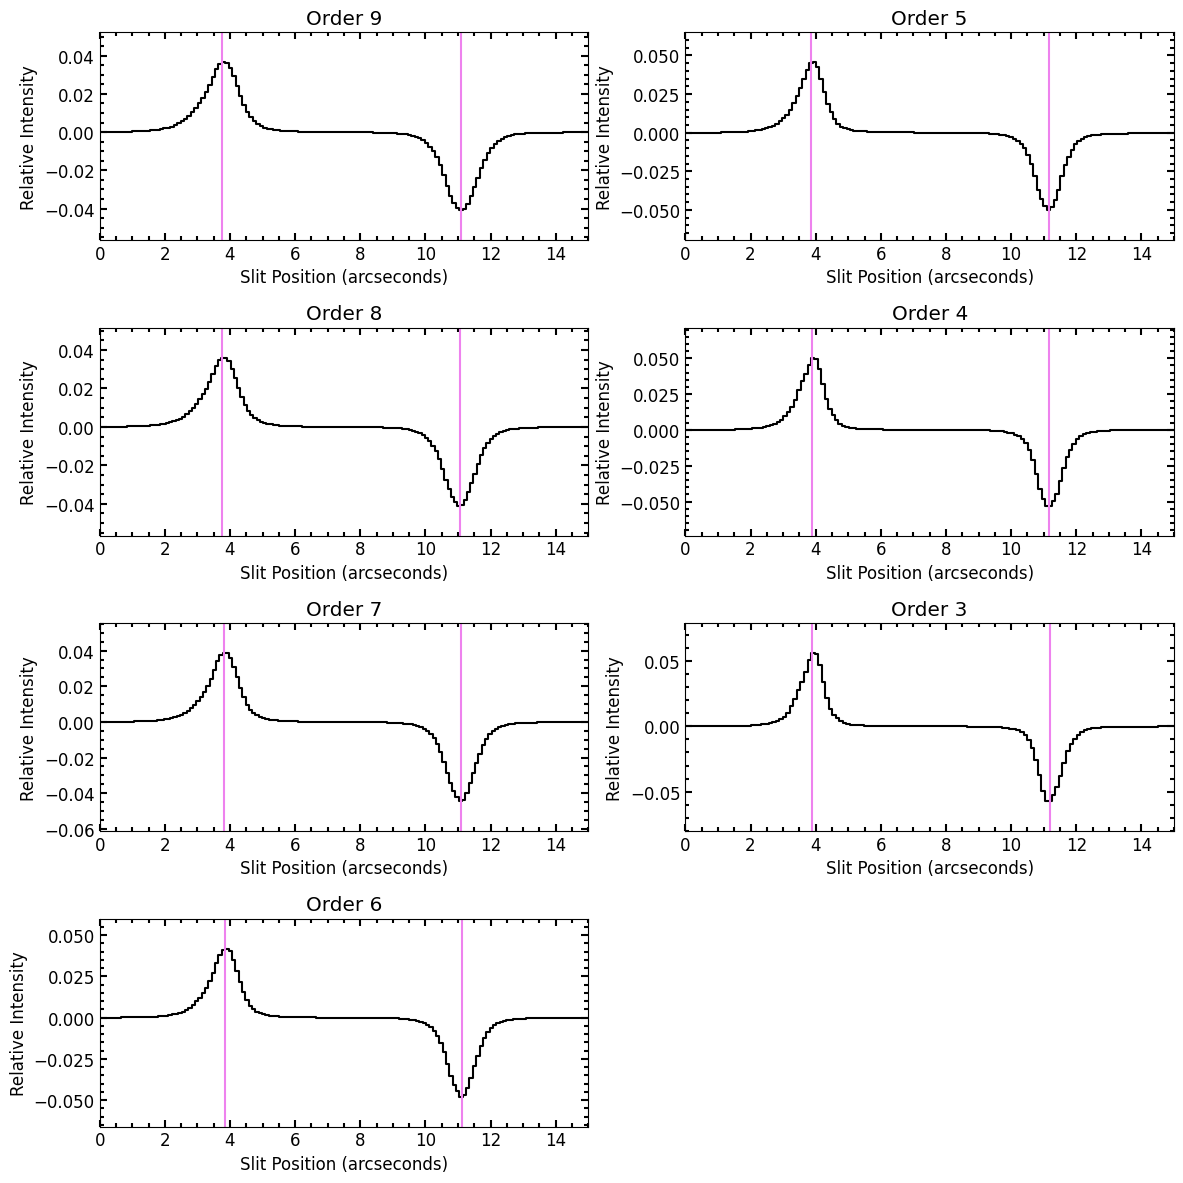

INFO:  Tracing apertures.


100% |**********************************************************************|


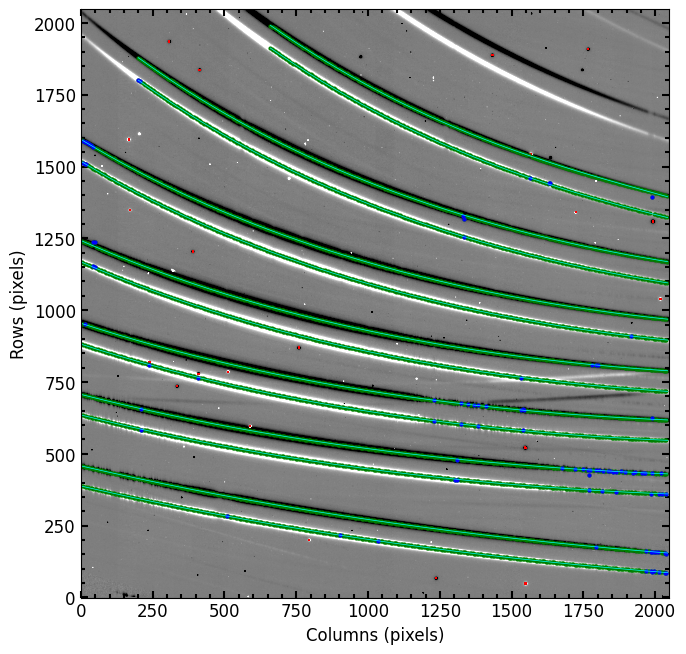

INFO:  Defining aperture parameters.


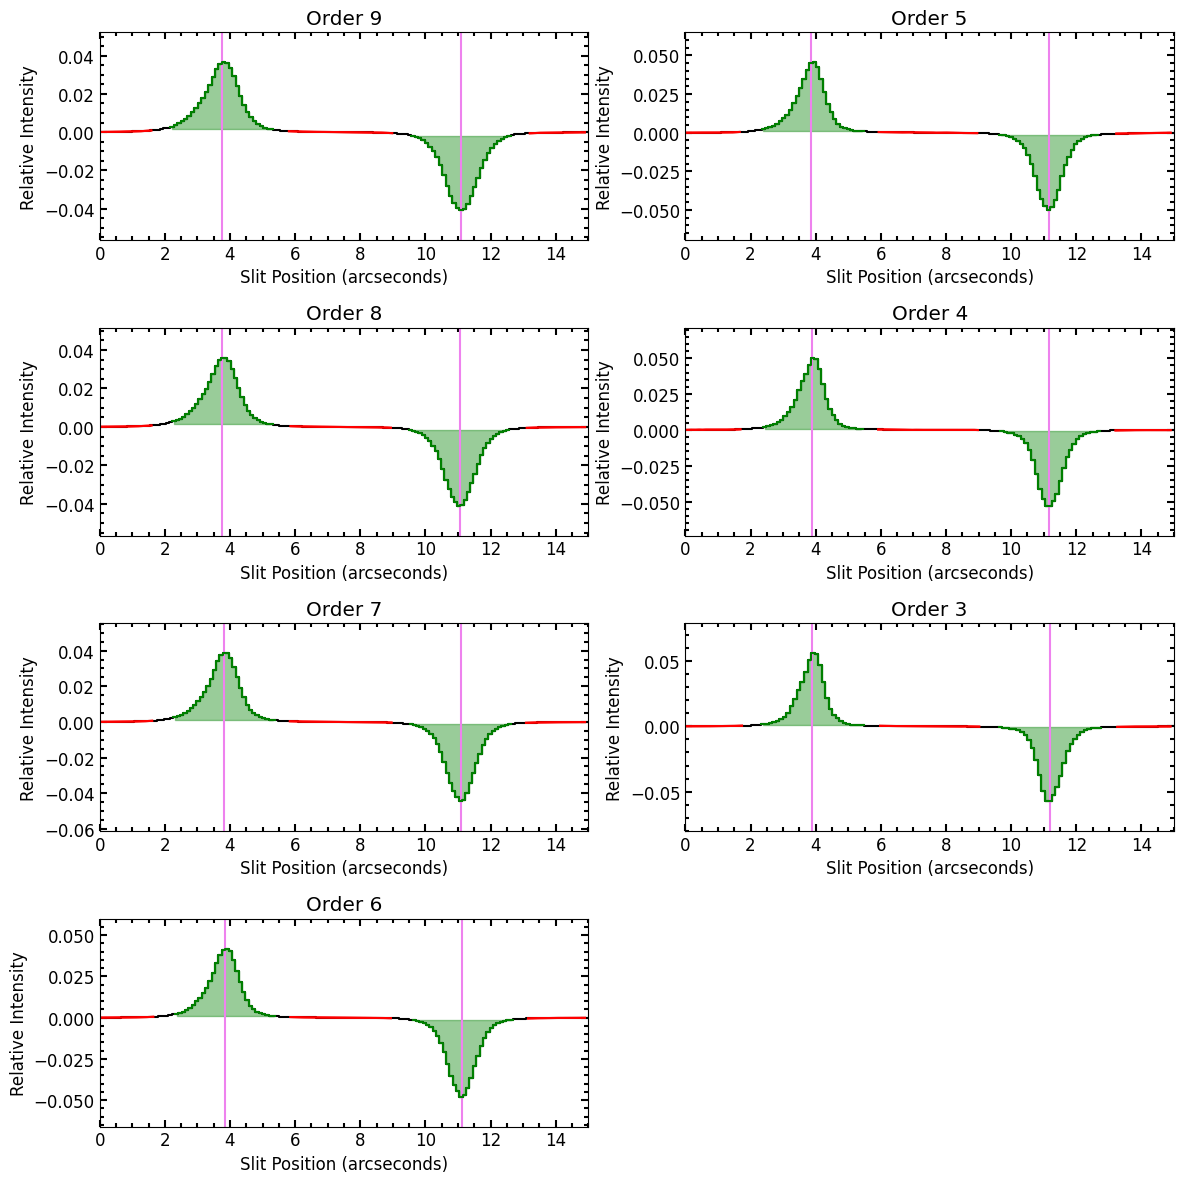

INFO:  Sum extracting 2 apertures in 7 orders (with background subtraction).


INFO:  Wrote file(s) A-B_bc_lc_flat_wc_fxbdpx-00011.fits, A-B_bc_lc_flat_wc_fxbdpx-00012.fits to proc/.



100% |**********************************************************************|


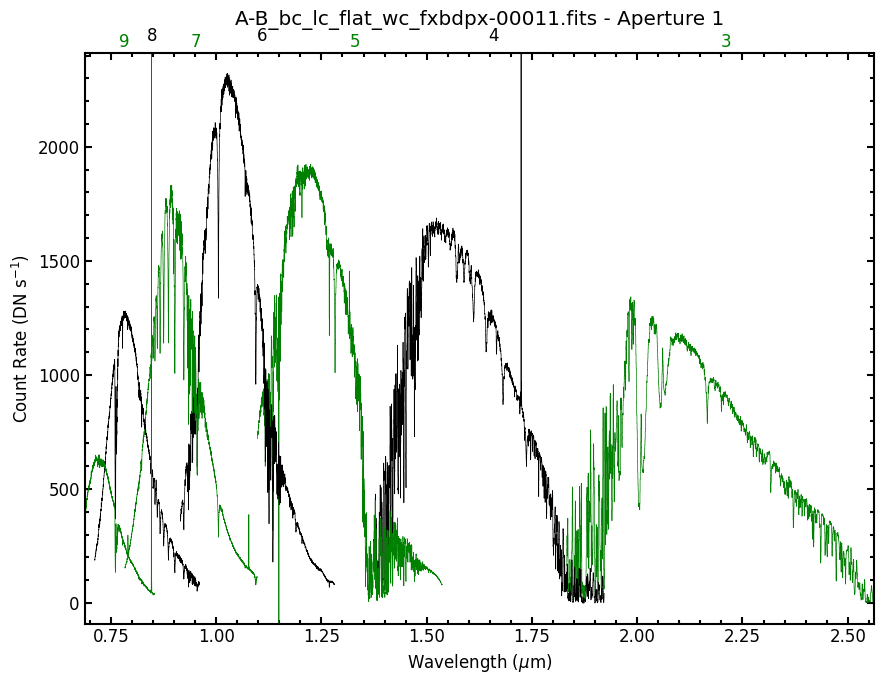

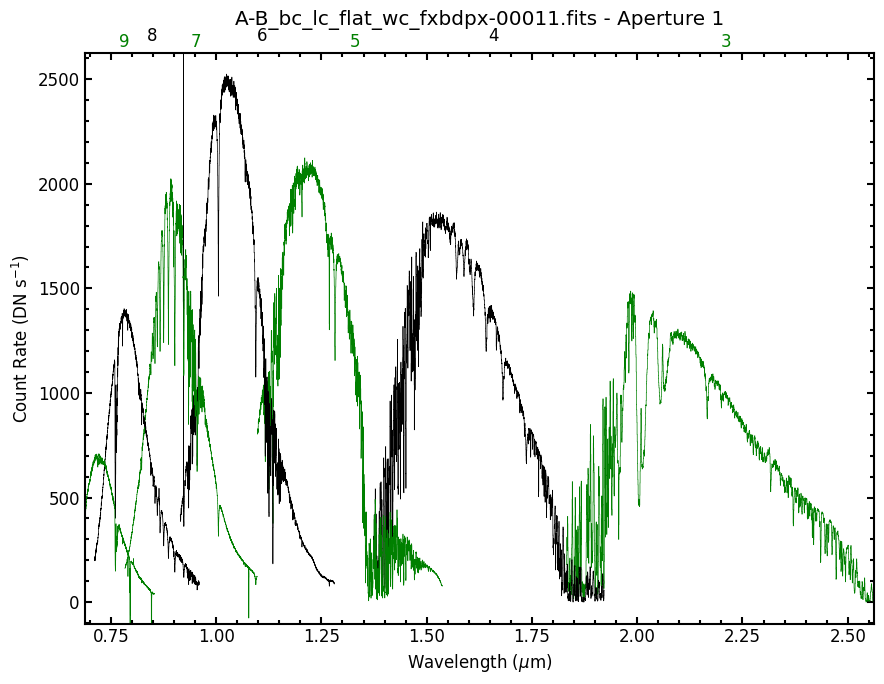

INFO:  Loading images(s) spc-00014.a.fits, spc-00013.b.fits correcting bias drift, and correcting for non-linearity.


100% |**********************************************************************|


INFO:  Flat fielding the image.
INFO:  Rectifying the orders.


100% |**********************************************************************|


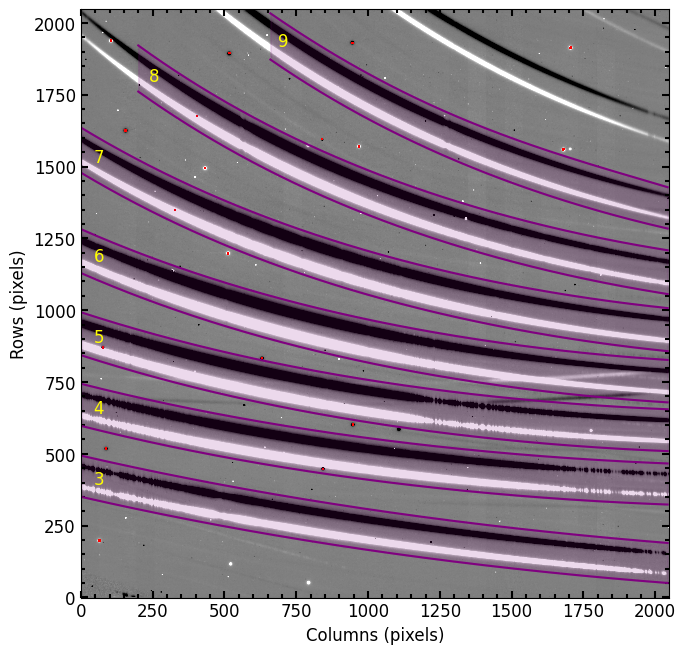

INFO:  Creating the 1D spatial profiles.


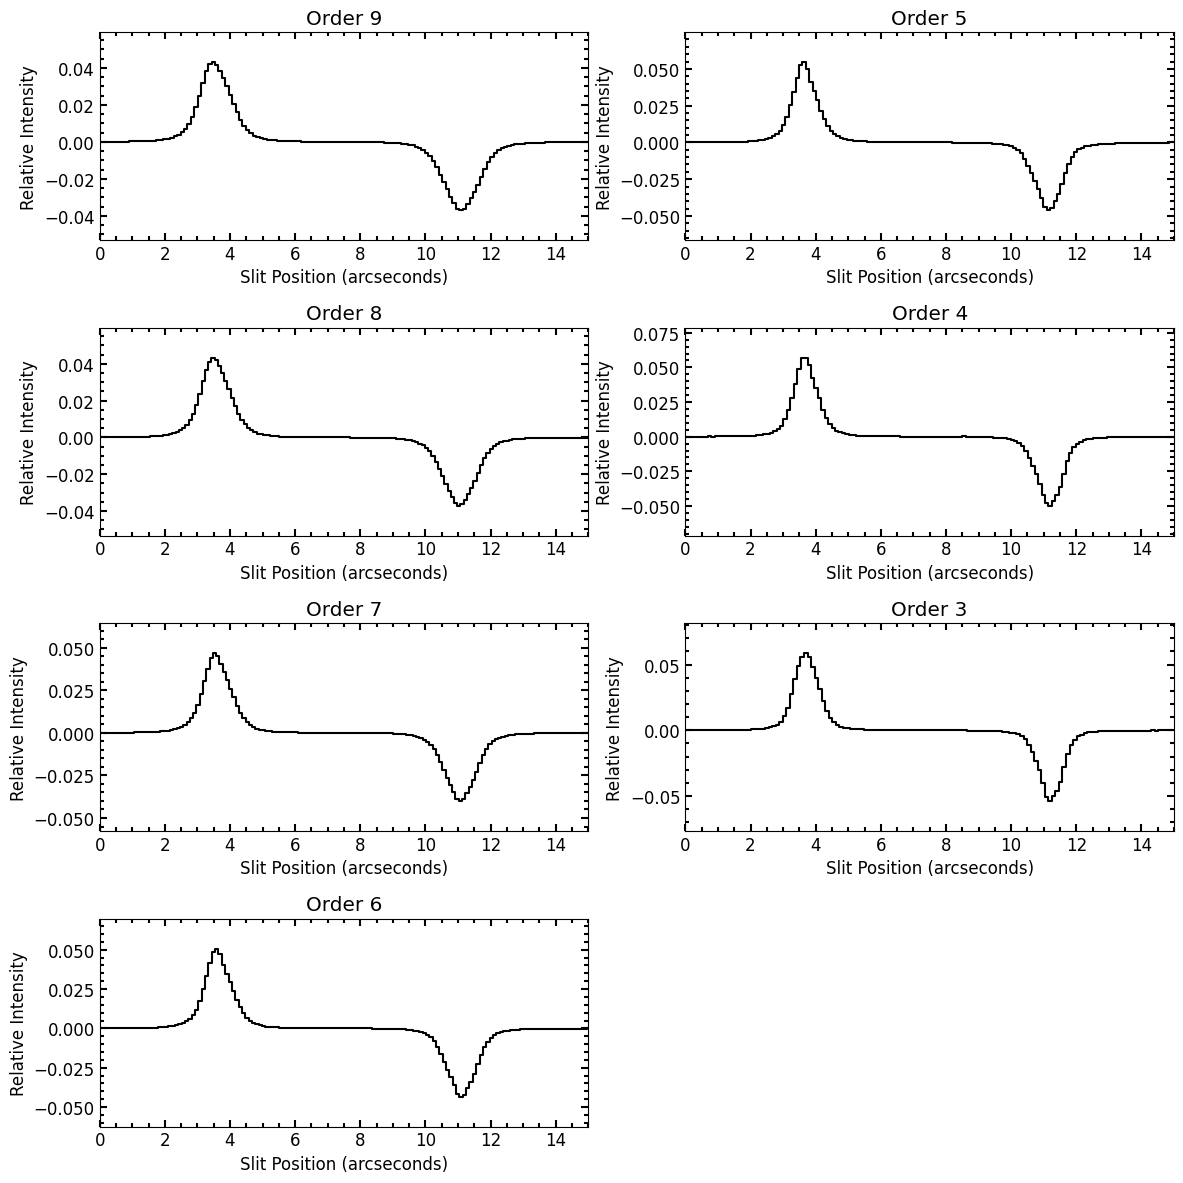

INFO:  Locating the apertures.
INFO:  Aperture signs are (+, -).


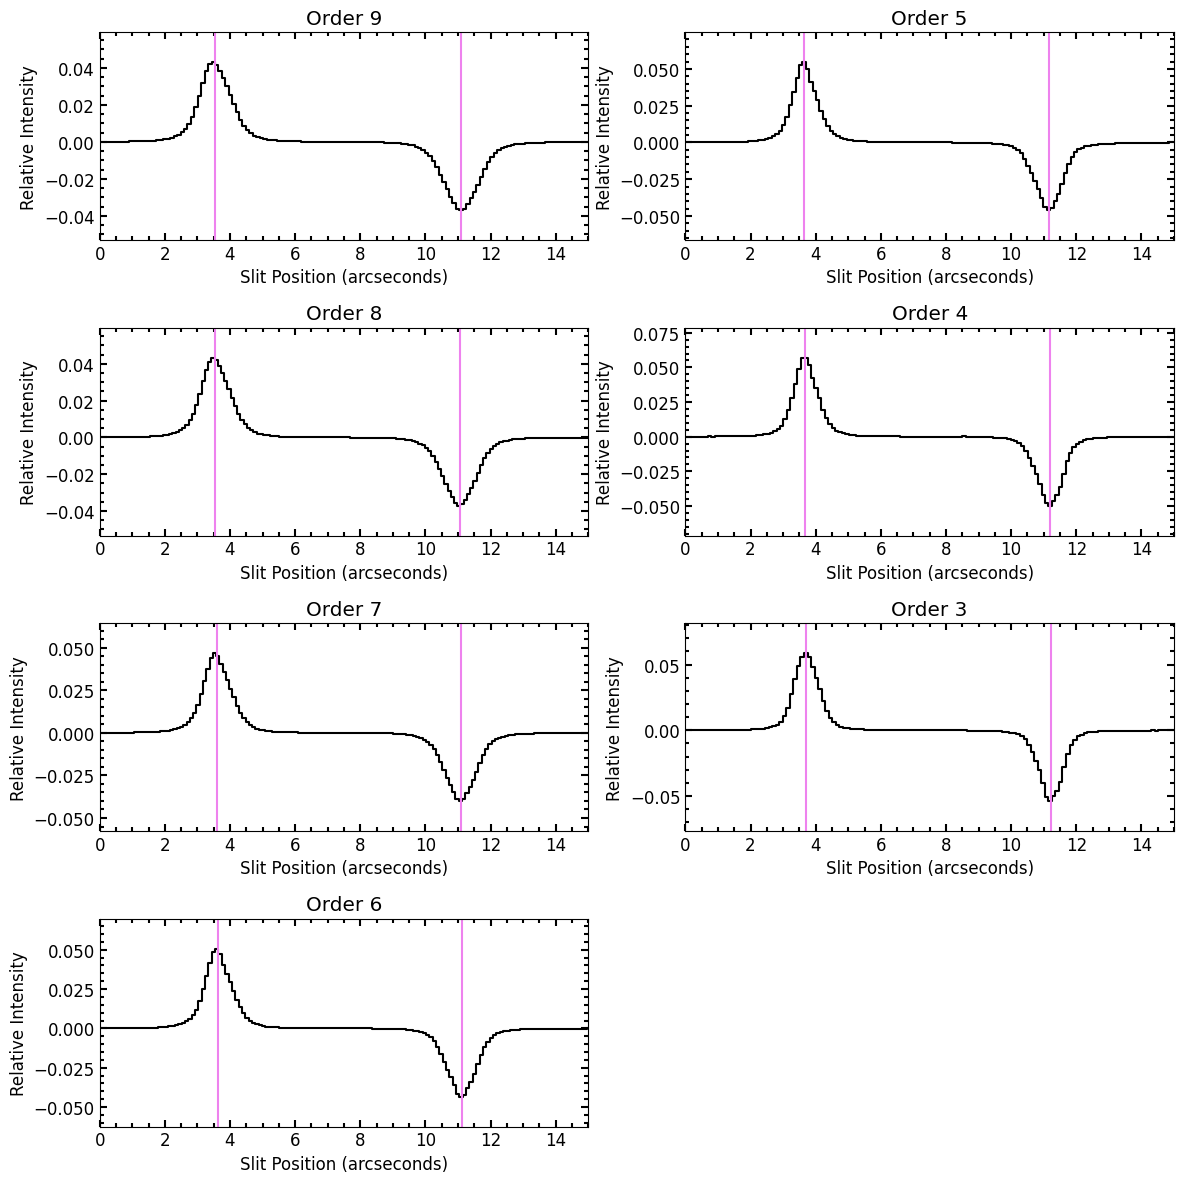

INFO:  Tracing apertures.


100% |**********************************************************************|


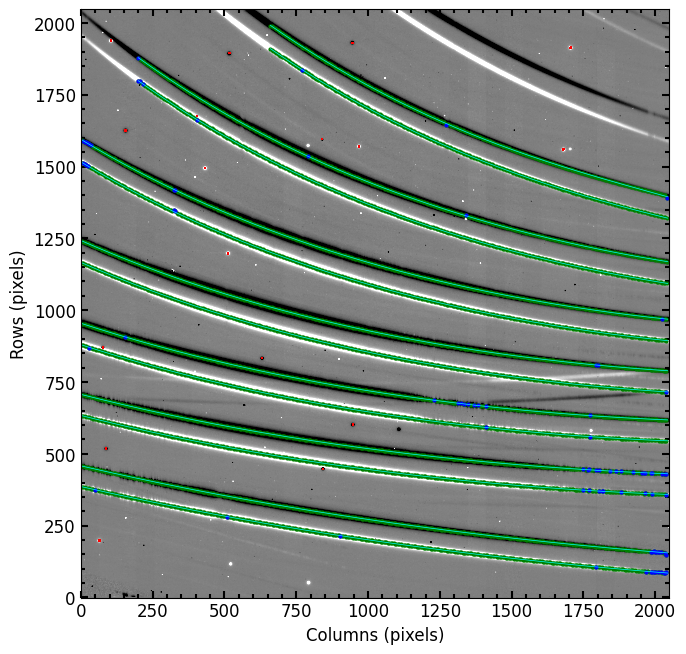

INFO:  Defining aperture parameters.


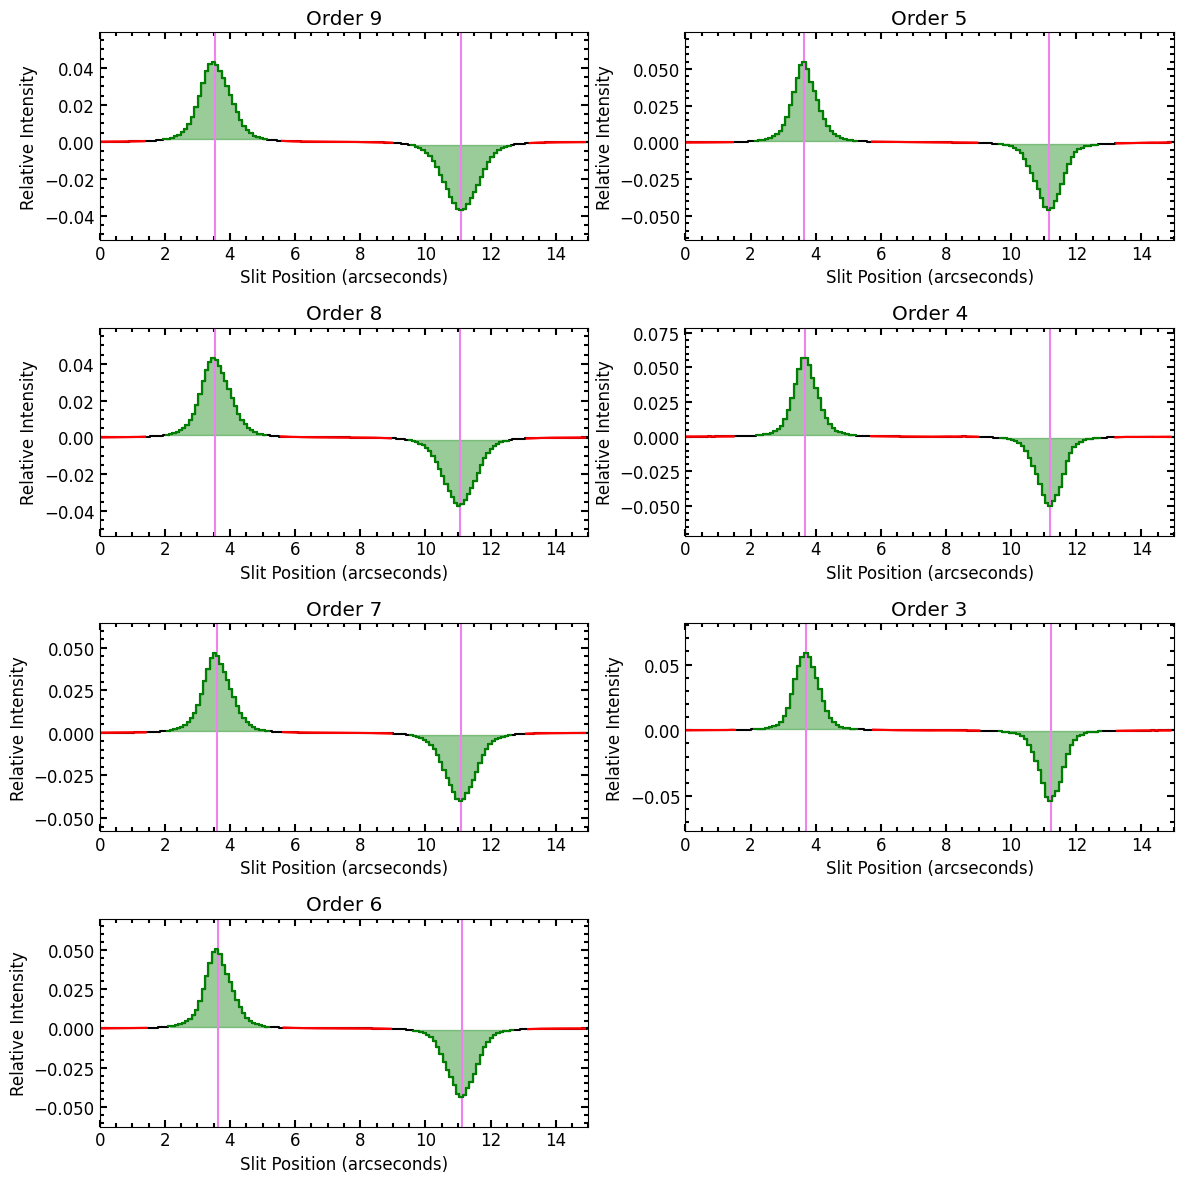

INFO:  Sum extracting 2 apertures in 7 orders (with background subtraction).


INFO:  Wrote file(s) A-B_bc_lc_flat_wc_fxbdpx-00014.fits, A-B_bc_lc_flat_wc_fxbdpx-00013.fits to proc/.



100% |**********************************************************************|


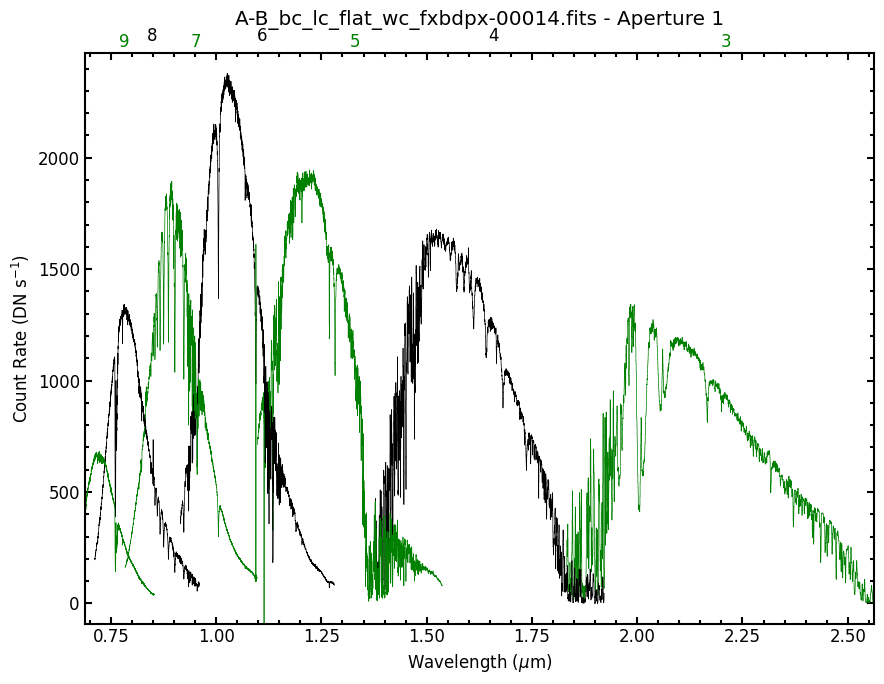

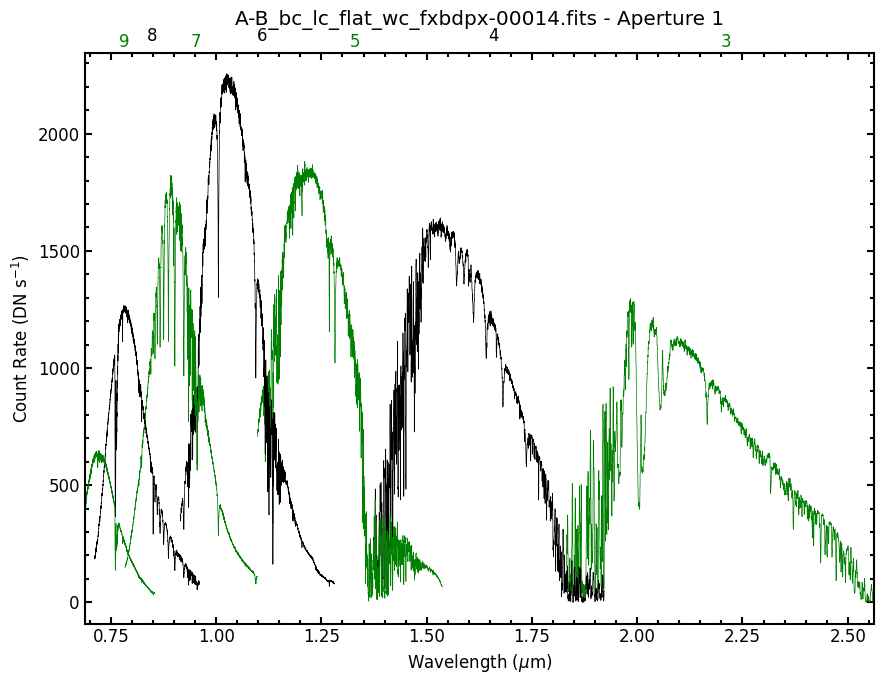

INFO:  Loading images(s) spc-00015.a.fits, spc-00016.b.fits correcting bias drift, and correcting for non-linearity.


100% |**********************************************************************|


INFO:  Flat fielding the image.
INFO:  Rectifying the orders.


100% |**********************************************************************|


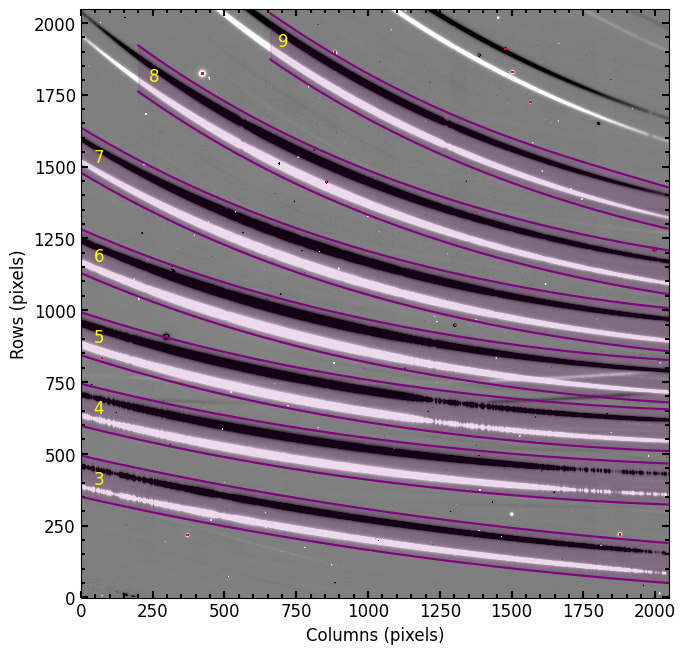

INFO:  Creating the 1D spatial profiles.


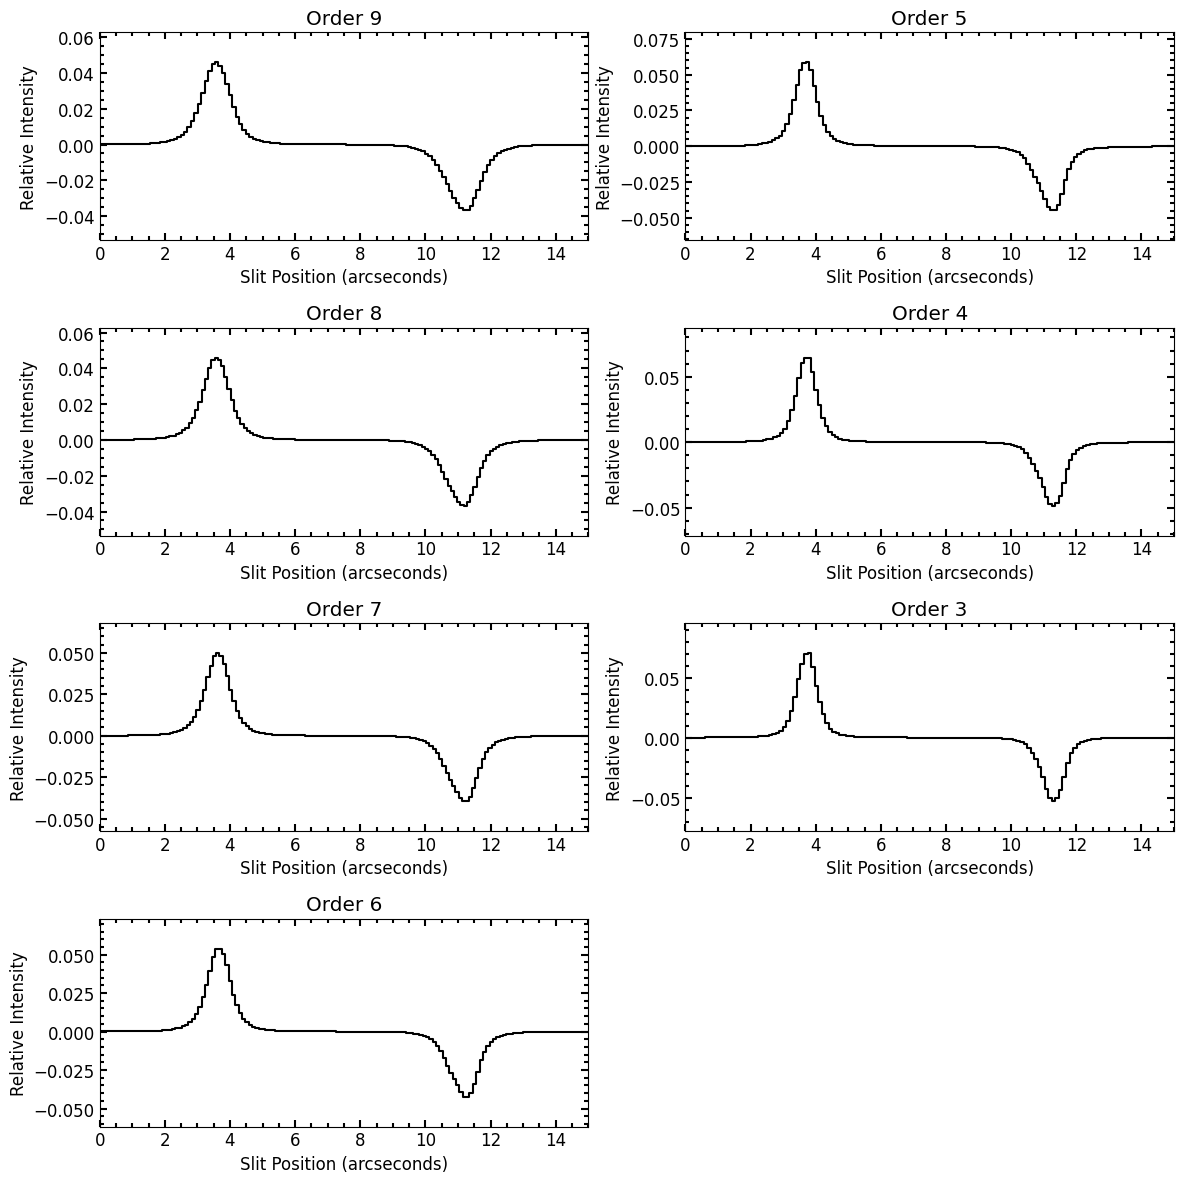

INFO:  Locating the apertures.
INFO:  Aperture signs are (+, -).


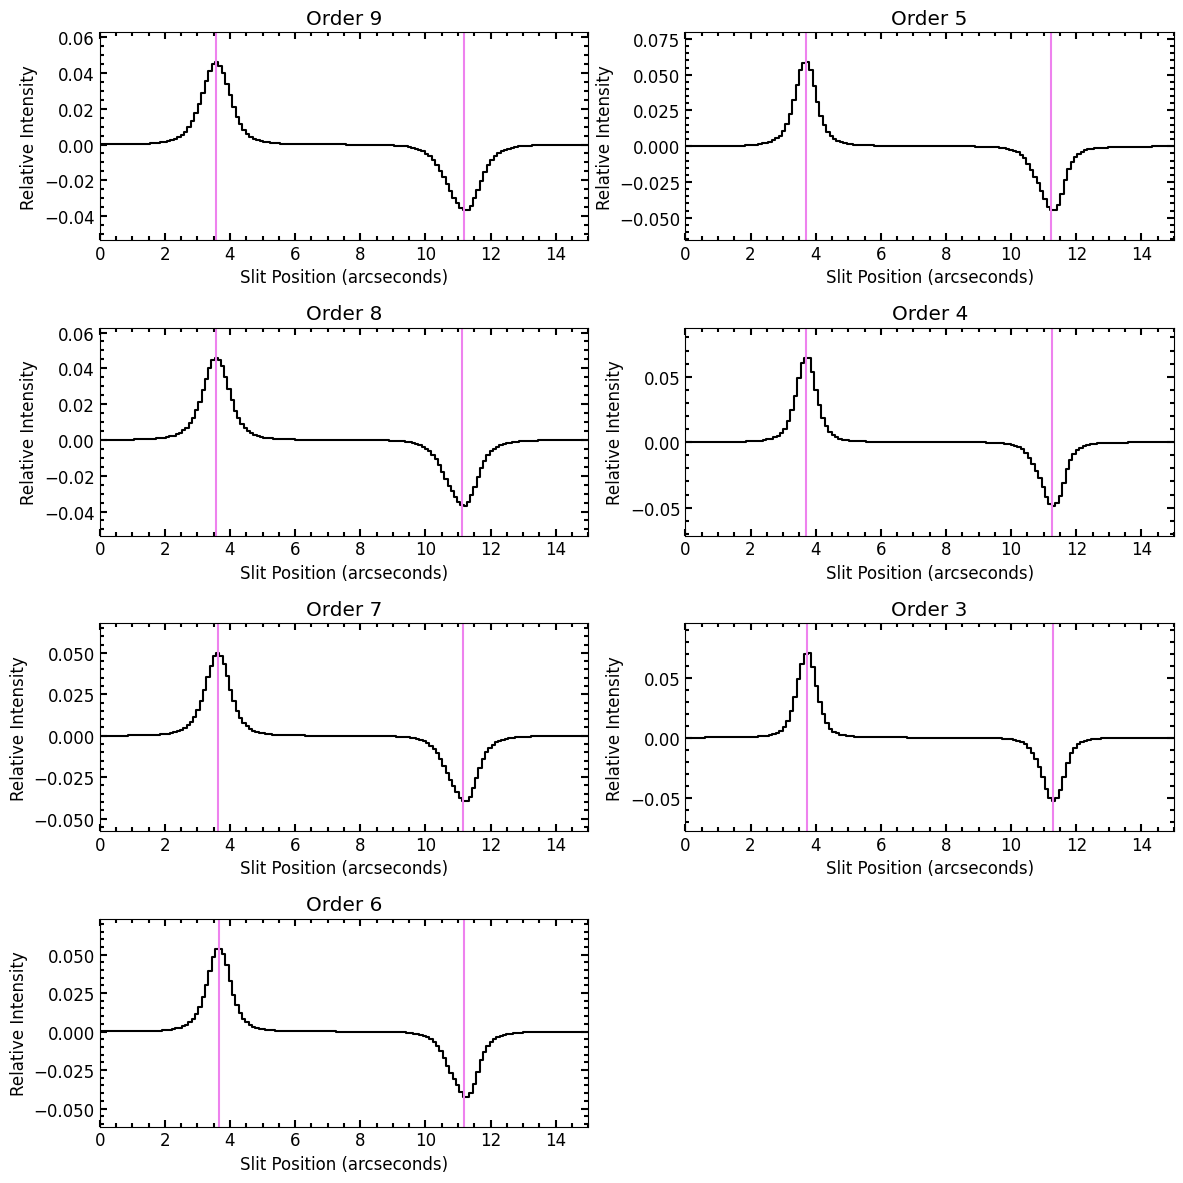

INFO:  Tracing apertures.


100% |**********************************************************************|


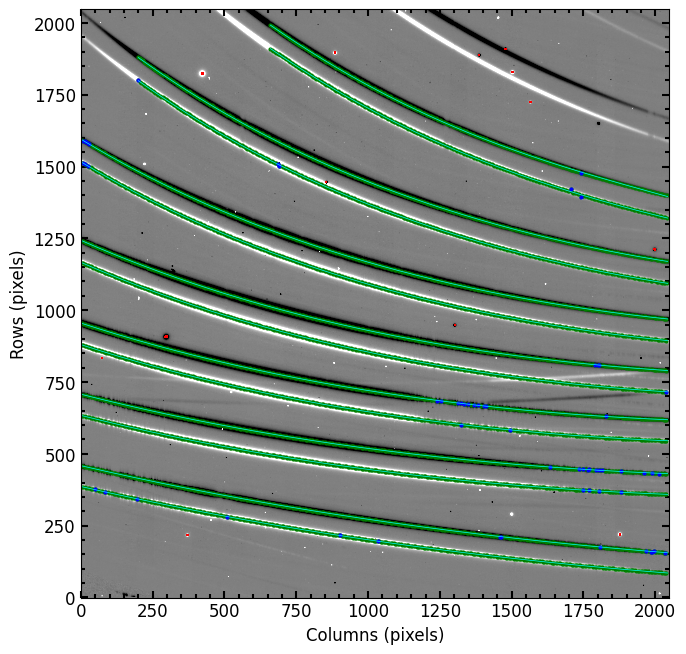

INFO:  Defining aperture parameters.


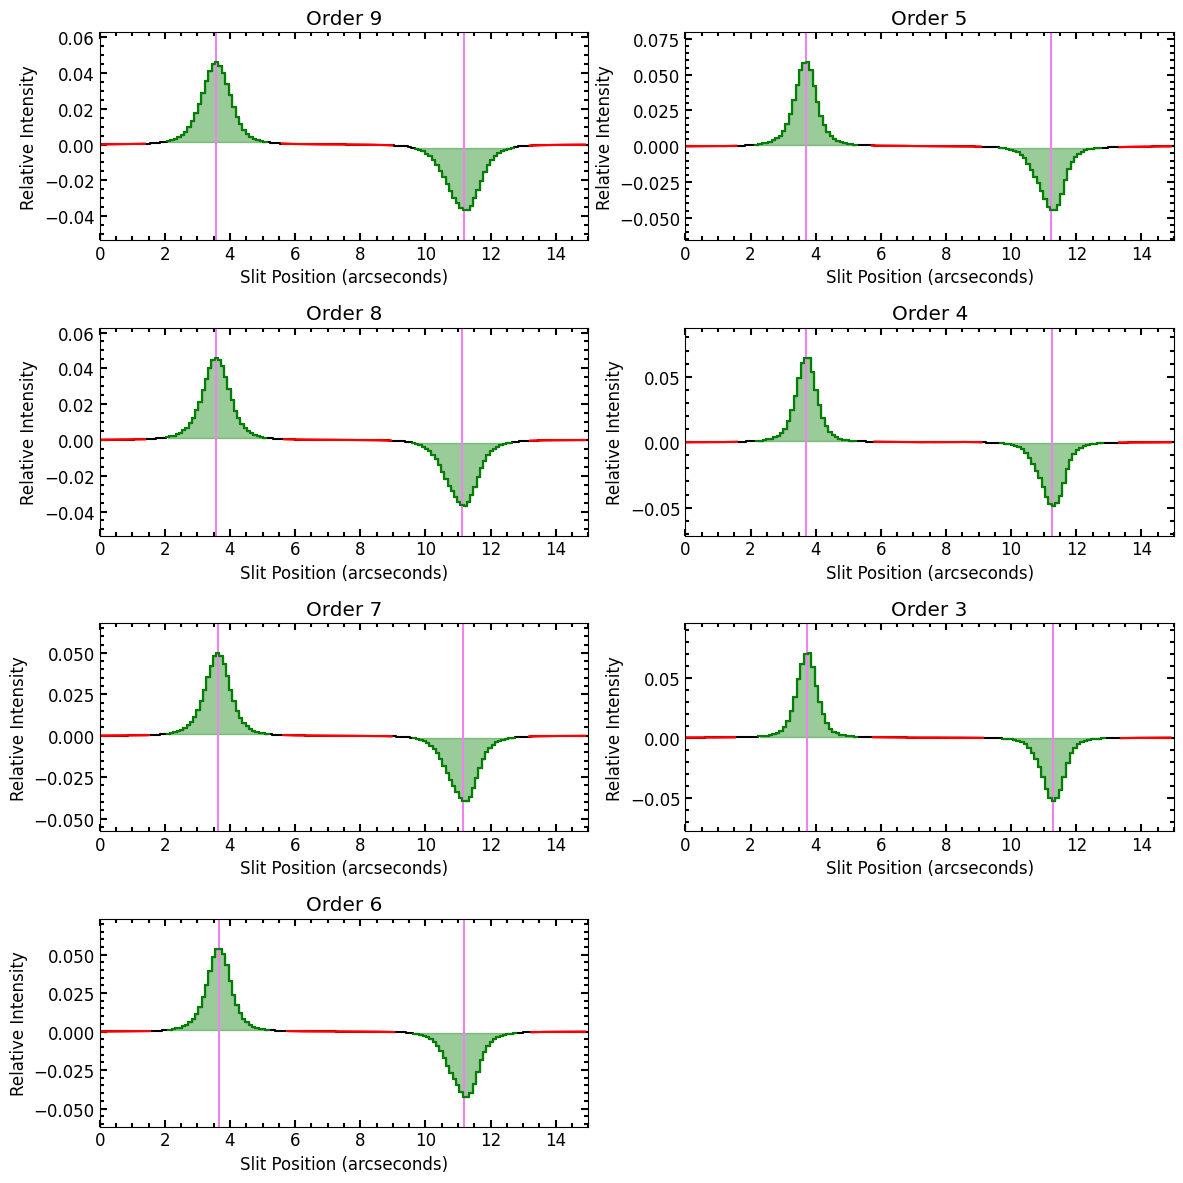

INFO:  Sum extracting 2 apertures in 7 orders (with background subtraction).


INFO:  Wrote file(s) A-B_bc_lc_flat_wc_fxbdpx-00015.fits, A-B_bc_lc_flat_wc_fxbdpx-00016.fits to proc/.



100% |**********************************************************************|


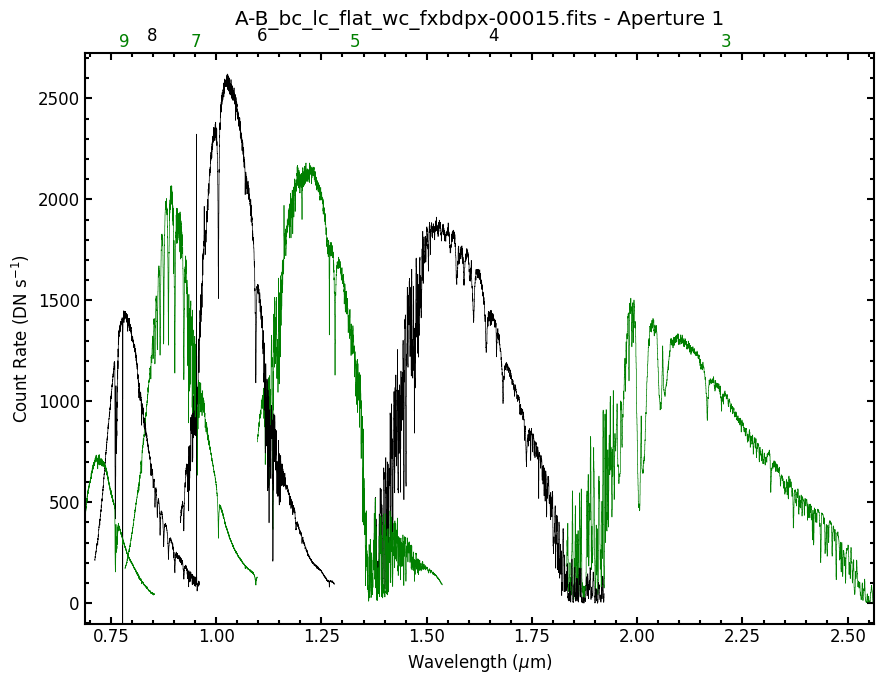

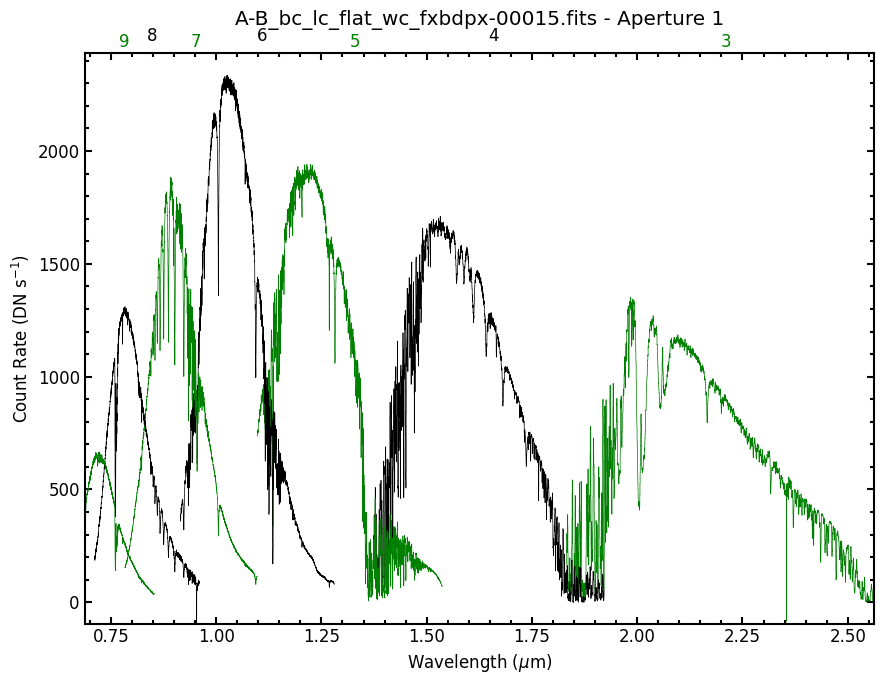

INFO:  Loading images(s) spc-00018.a.fits, spc-00017.b.fits correcting bias drift, and correcting for non-linearity.


100% |**********************************************************************|


INFO:  Flat fielding the image.
INFO:  Rectifying the orders.


In [ ]:
# ============================================================================
# EXTRACT STANDARD
# ============================================================================
# Extract spectra from telluric standard observations

ps.extract.extract(mode,
                   [src_prefix, std_files],
                   flatfield_file,
                   wavecal_file,
                   aperture_find,
                   aperture,
                   flat_field=flat_field,
                   linearity_correction=correct_linearity,
                   output_prefix=output_prefix,
                   write_rectified_orders=False,
                   aperture_signs=aperture_signs,
                   include_orders=include_orders,
                   bg_annulus=bg_annulus,
                   fix_badpixels=fix_badpixels,
                   psf_radius=psf_radius,
                   detector_info={'correct_bias':correct_bias})


## Extract science files

In [ ]:
# ============================================================================
# EXTRACT SCIENCE
# ============================================================================
# Extract spectra from science target observations

ps.extract.extract(mode,
                   [src_prefix, files],
                   flatfield_file,
                   wavecal_file,
                   aperture_find,
                   aperture,
                   flat_field=flat_field,
                   linearity_correction=correct_linearity,
                   output_prefix=output_prefix,
                   write_rectified_orders=False,
                   aperture_signs=aperture_signs,
                   include_orders=include_orders,
                   bg_annulus=bg_annulus,
                   fix_badpixels=fix_badpixels,
                   psf_radius=psf_radius,
                   detector_info={'correct_bias':correct_bias})


## Combine standard and science spectra

In [ ]:
# Combine standard spectra
ps.combine.combine(['A-B_bc_lc_flat_wc_fxbdpx-', std_files], std_name)


In [ ]:
# Combine science target spectra
ps.combine.combine(['A-B_bc_lc_flat_wc_fxbdpx-', files], obj_name)


# Perform telluric correction with science target and standard

In [ ]:
# ============================================================================
# TELLURIC CORRECTION
# ============================================================================
# Correct science spectrum for telluric absorption using standard star

ps.telluric.telluric(obj_name+'.fits',
                     std_name+'.fits',
                     std_name,
                     'calspec'+files,
                     write_model_spectra=write_model_spectra)


# Checking your outputs

You should find several output files in your cals and proc folders that allow you to visualize the calibrations and extractions. In addition, you can read in the spectrum and visualize it with plot_spectra.py


In [ ]:
# ============================================================================
# PLOT RESULTS
# ============================================================================

from pyspextool.plot.plot_spectra import plot_spectra

file = 'calspec1-8.fits'
ax = plot_spectra(proc+file,
                  colors='k',
                  ytype="flux and uncertainty",
                  order_numbers=False)
